In [51]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV

noise = 16
seed = 244823
samples = 2423
loop = 10
plt.rcParams['figure.figsize'] = [8, 8]


class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples_split and curr_depth<self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("Feature "+str(tree.feature_index), "=", tree.threshold, ", information gain:", tree.info_gain)
            print("%sleft: " % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright: " % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):

        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

def cm(ytest, ypred, title, showplot=True):
    cm = confusion_matrix(ytest, ypred)
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    balacc = (sensitivity+specificity)/2
    f1score = 2*(sensitivity*specificity)/(specificity+sensitivity)

    if showplot:
        cm = ConfusionMatrixDisplay(confusion_matrix=cm)
        cm.plot(cmap='binary')
        plt.title(title)
        plt.show()
    return sensitivity, specificity, balacc, f1score

def kontur(xtrain, ytrain, title):

    x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
    y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = np.asarray(classifier.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.title(title)
    plt.contourf(xx, yy, Z, alpha=0.6)
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
    plt.show()

def sklkontur(xtrain, ytrain, title):

    x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
    y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = np.asarray(tree_model.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.title(title)
    plt.contourf(xx, yy, Z, alpha=0.6)
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
    plt.show()


<h3 align="center"><font size="10">Część 1</font></h3>

<h3 align="center"><font size="10">1 klaster na klasę / max depth = liczba cech</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

In [42]:
x, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True, stratify=y)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)

In [43]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=2)
classifier.fit(xtrain, ytrain)

In [4]:
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
own_endtime_features = (time.time() - start)/loop
print(own_endtime_features)

13.148491549491883


In [44]:
ypred = classifier.predict(xtest)

[-0.55449403 -0.56272039] 0
[-0.55449403 -0.56272039] 0
[ 0.4684775  -1.55499083] 0
[ 0.4684775  -1.55499083] 1
[-1.6175636  -1.39553306] 0
[-1.6175636  -1.39553306] 0
[ 0.6515947 -1.1575137] 0
[ 0.6515947 -1.1575137] 1
[-0.41573315 -1.54646536] 0
[-0.41573315 -1.54646536] 0
[ 1.10998099 -2.13395153] 0
[ 1.10998099 -2.13395153] 1
[-1.04562482 -0.83056243] 0
[-1.04562482 -0.83056243] 0
[-0.46228399 -0.57709567] 0
[-0.46228399 -0.57709567] 0
[ 1.46236076 -0.41124595] 0
[ 1.46236076 -0.41124595] 1
[-1.14351753 -1.31397922] 0
[-1.14351753 -1.31397922] 0
[ 1.64273252 -0.58840137] 0
[ 1.64273252 -0.58840137] 1
[-0.07427053 -2.07234254] 0
[-0.07427053 -2.07234254] 0
[-0.283777   -0.78038741] 0
[-0.283777   -0.78038741] 0
[ 0.91111595 -0.35329136] 0
[ 0.91111595 -0.35329136] 1
[-1.64463108 -1.92478763] 0
[-1.64463108 -1.92478763] 0
[ 0.90407019 -0.96739309] 0
[ 0.90407019 -0.96739309] 1
[-0.68209478 -2.89382858] 0
[-0.68209478 -2.89382858] 0
[-0.11002214 -0.51965762] 0
[-0.11002214 -0.51965762

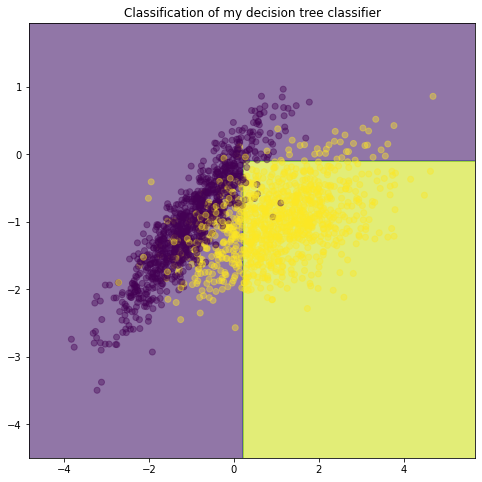

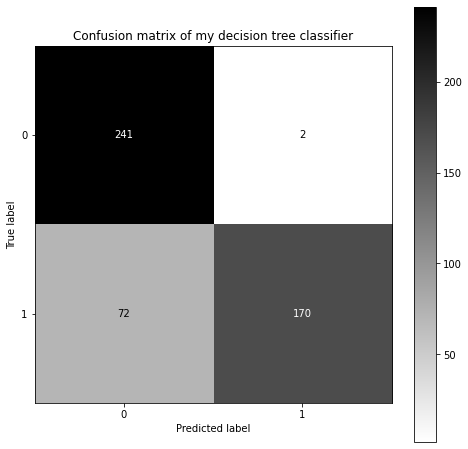

In [6]:
kontur(xtrain, ytrain, 'Classification of my decision tree classifier')
own_sensitivity_features_1cl, own_specificity_features_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my decision tree classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

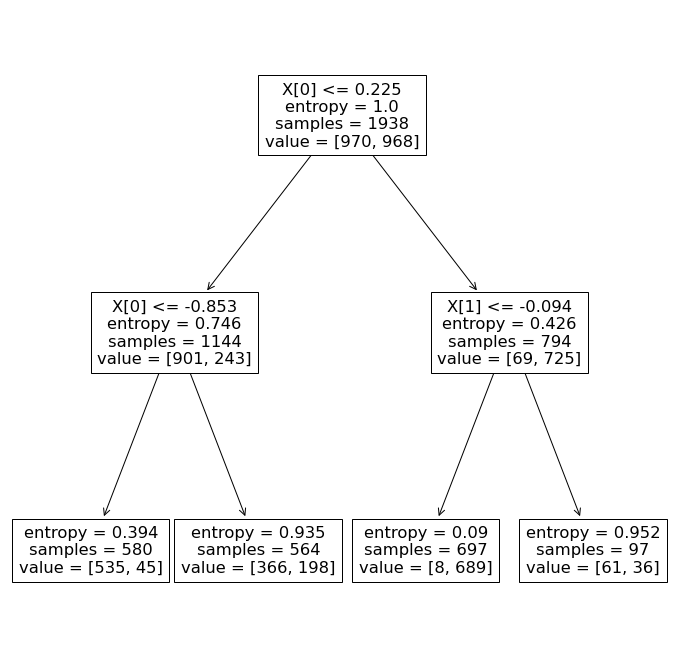

In [7]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=2, criterion='entropy')
tree_model = tree_model.fit(xtrain, ytrain)
plt.rcParams['figure.figsize'] = [12, 12]
tree.plot_tree(tree_model)
plt.show()

In [8]:
start = time.time()
for i in range(loop):
    tree_model = tree_model.fit(xtrain, ytrain)
    ypred = tree_model.predict(xtest)
skl_endtime_features = (time.time() - start)/loop
print(skl_endtime_features)

0.0016926765441894532


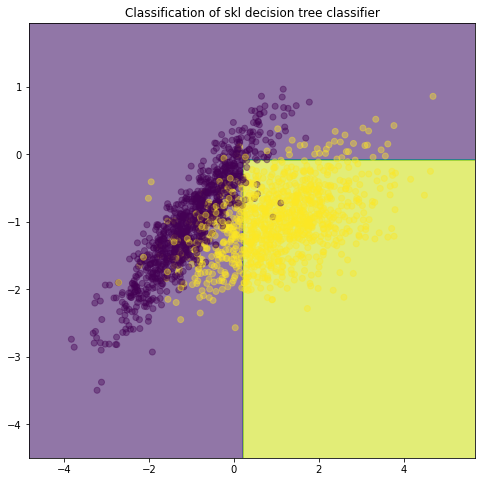

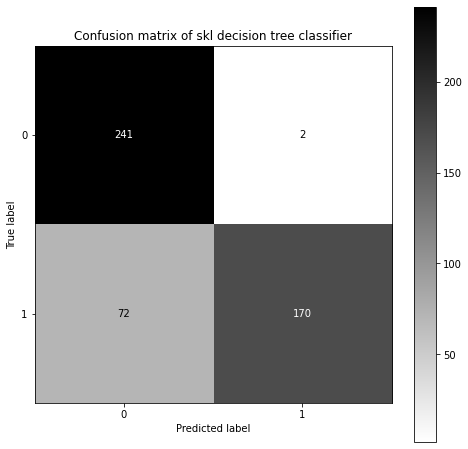

In [9]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl decision tree classifier')
skl_sensitivity_features_1cl, skl_specificity_features_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl decision tree classifier')

<h3 align="center"><font size="10">1 klaster na klasę / max depth = liczba próbek</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

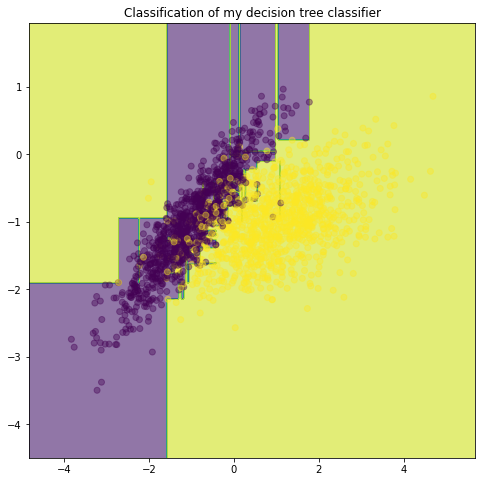

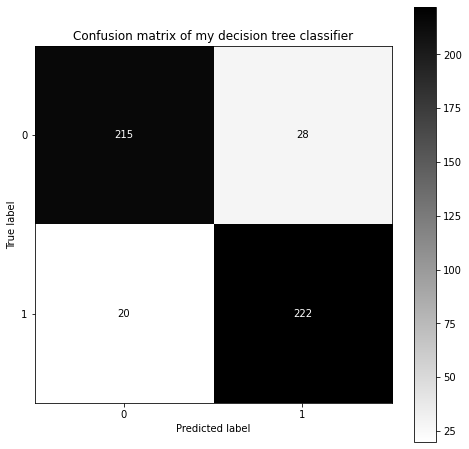

In [10]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=1938)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
kontur(xtrain, ytrain, 'Classification of my decision tree classifier')
own_sensitivity_max_1cl, own_specificity_max_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my decision tree classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

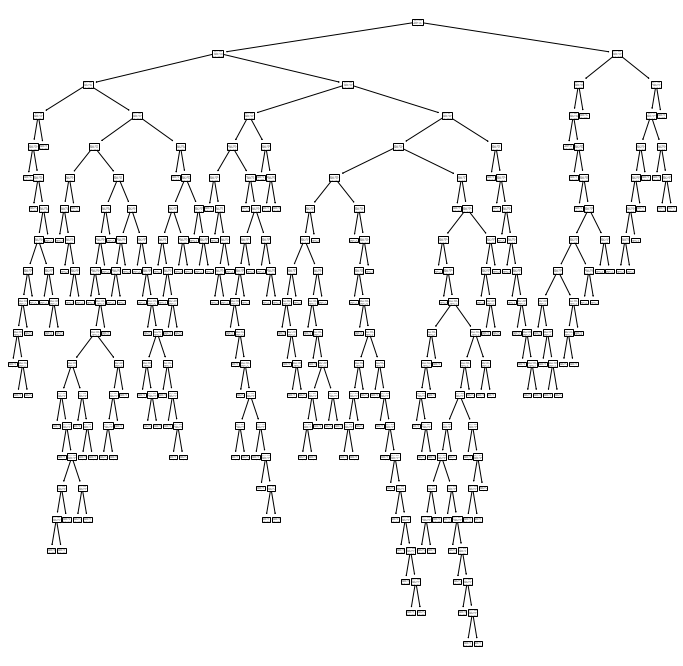

In [11]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=1938, criterion='entropy')
tree_model = tree_model.fit(xtrain, ytrain)
plt.rcParams['figure.figsize'] = [12, 12]
tree.plot_tree(tree_model)
plt.show()

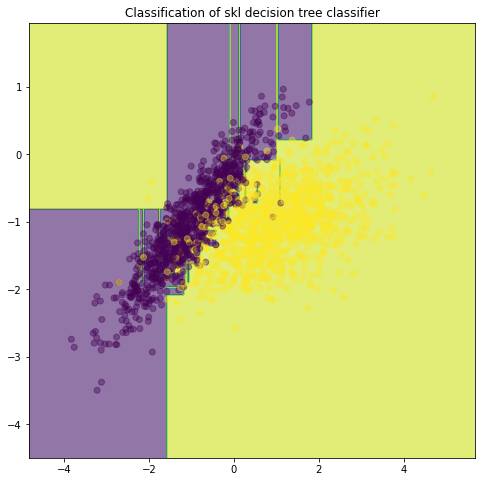

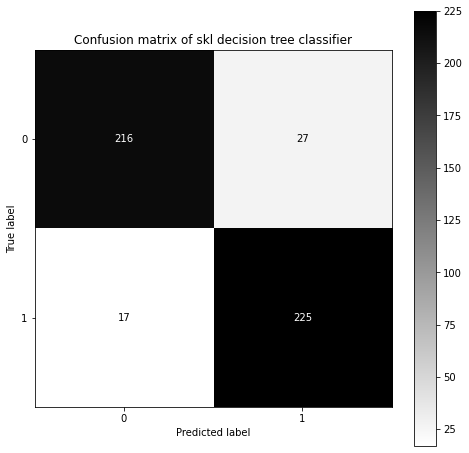

In [12]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl decision tree classifier')
skl_sensitivity_max_1cl, skl_specificity_max_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl decision tree classifier')

<h3 align="center"><font size="10">2 klastry na klasę / max depth = liczba cech</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

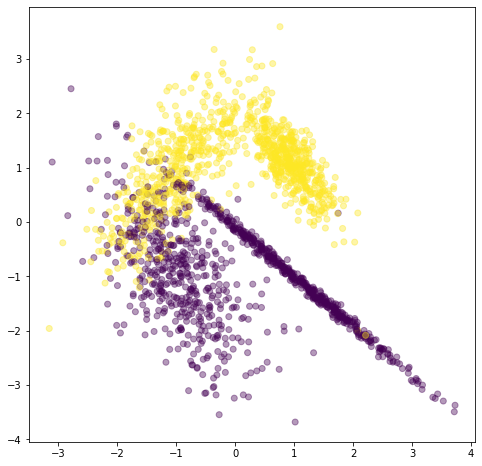

In [13]:
x, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=2, n_informative=2)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True, stratify=y)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
plt.show()

In [14]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=2)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)

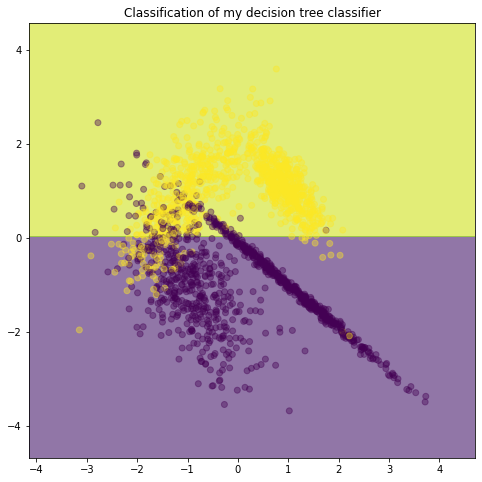

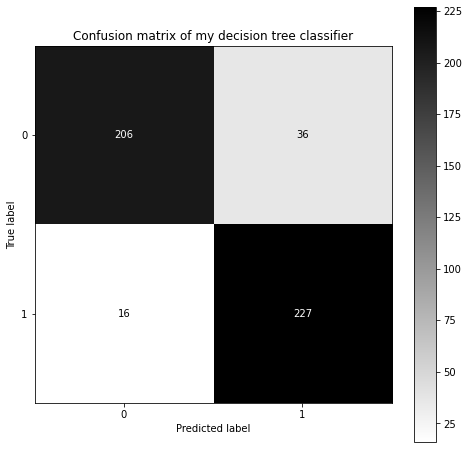

In [15]:
kontur(xtrain, ytrain, 'Classification of my decision tree classifier')
own_sensitivity_features_2cl, own_specificity_features_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my decision tree classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

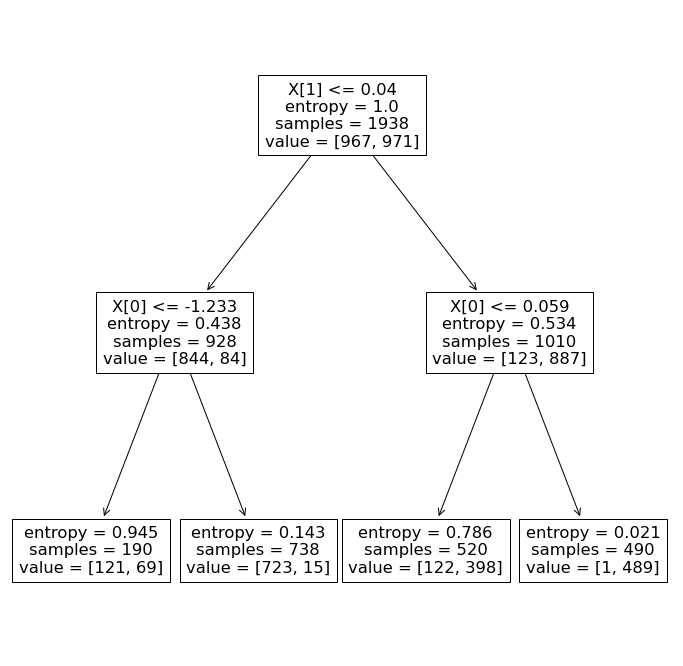

In [16]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=2, criterion='entropy')
tree_model = tree_model.fit(xtrain, ytrain)
plt.rcParams['figure.figsize'] = [12, 12]
tree.plot_tree(tree_model)
plt.show()

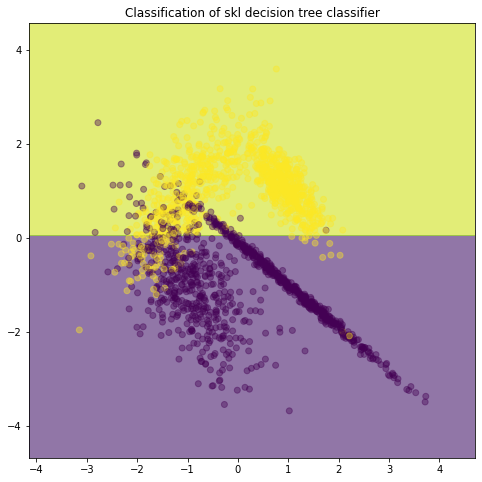

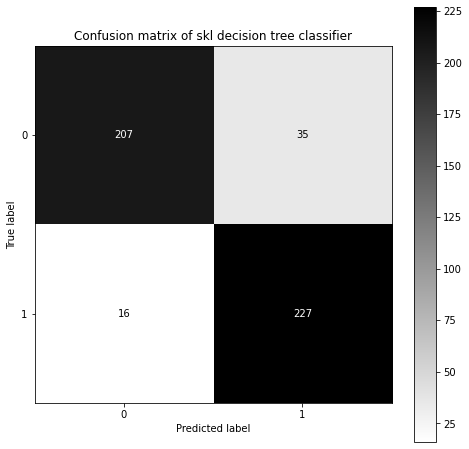

In [17]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl decision tree classifier')
skl_sensitivity_features_2cl, skl_specificity_features_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl decision tree classifier')

<h3 align="center"><font size="10">2 klastry na klasę / max depth = liczba próbek</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

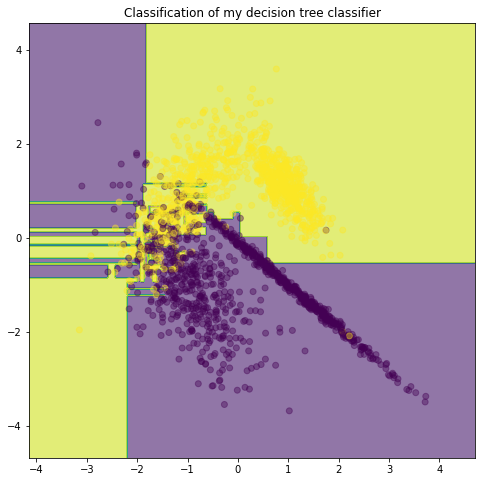

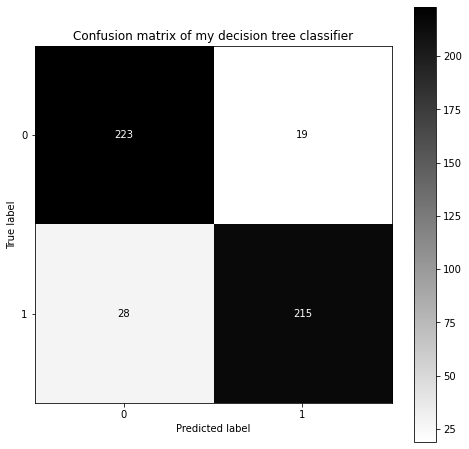

In [18]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=1938)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
kontur(xtrain, ytrain, 'Classification of my decision tree classifier')
own_sensitivity_max_2cl, own_specificity_max_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my decision tree classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

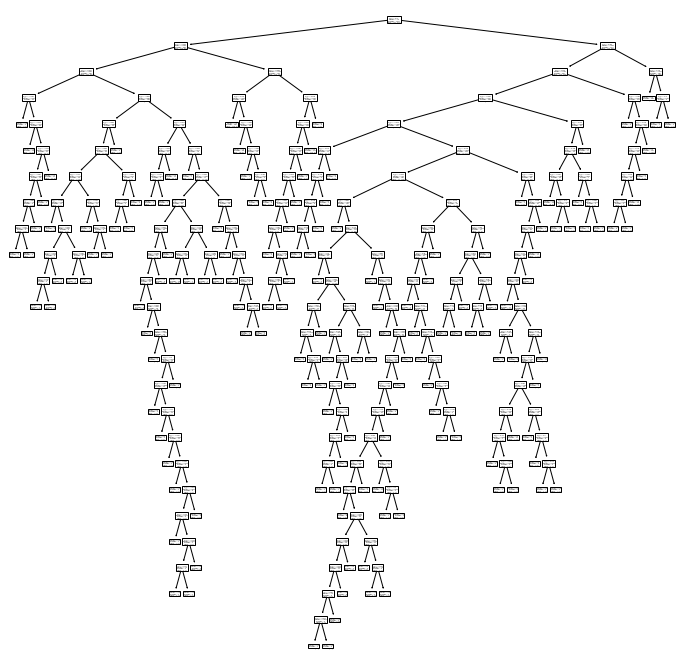

In [19]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=1938, criterion='entropy')
tree_model = tree_model.fit(xtrain, ytrain)
plt.rcParams['figure.figsize'] = [12, 12]
tree.plot_tree(tree_model)
plt.show()

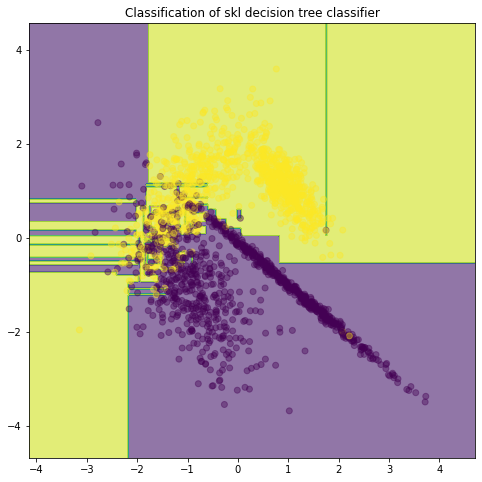

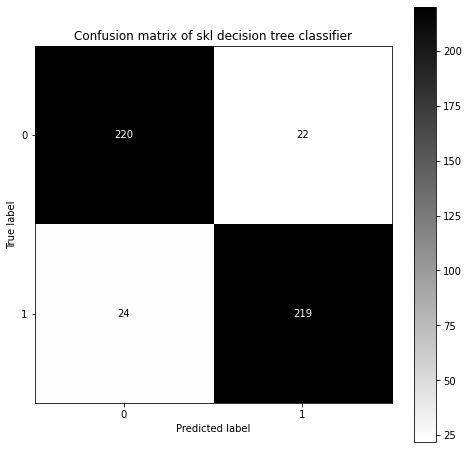

In [20]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl decision tree classifier')
skl_sensitivity_max_2cl, skl_specificity_max_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl decision tree classifier')

<h3 align="center"><font size="10">2 klastry na klasę / max depth = liczba klastrów</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

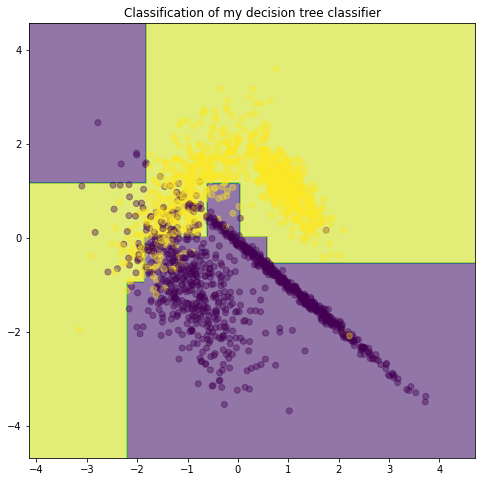

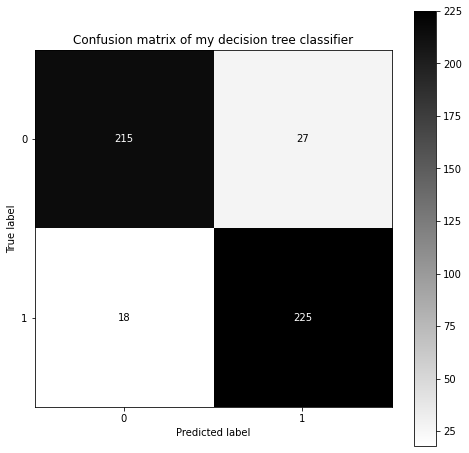

In [21]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=4)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
kontur(xtrain, ytrain, 'Classification of my decision tree classifier')
own_sensitivity_clusters_2cl, own_specificity_clusters_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my decision tree classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

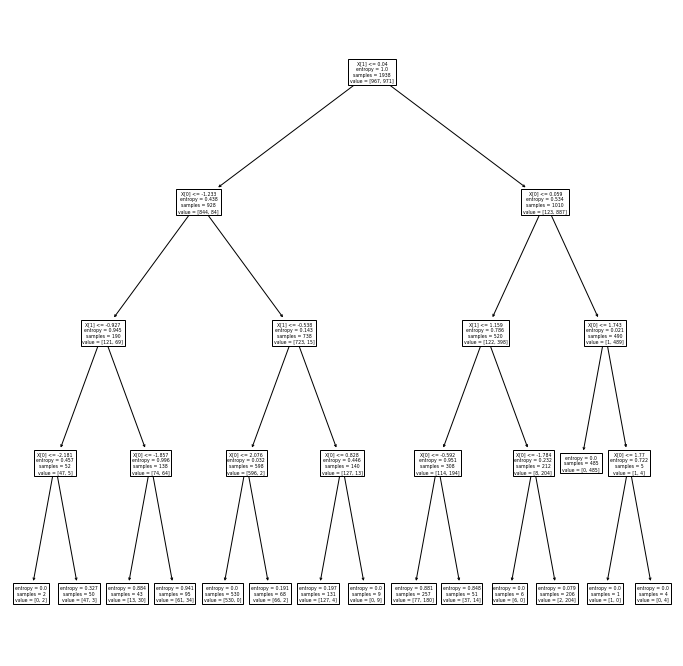

In [22]:
tree_model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=4, criterion='entropy')
tree_model = tree_model.fit(xtrain, ytrain)
plt.rcParams['figure.figsize'] = [12, 12]
tree.plot_tree(tree_model)
plt.show()

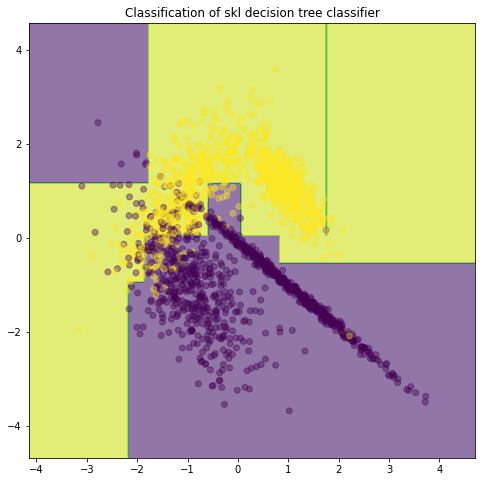

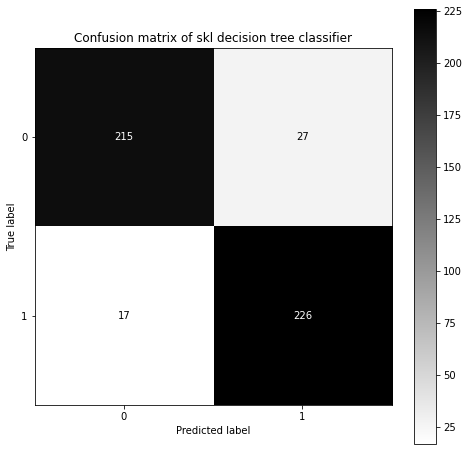

In [23]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl decision tree classifier')
skl_sensitivity_clusters_2cl, skl_specificity_clusters_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl decision tree classifier')

In [24]:
print(f'The runtime of my own model is {own_endtime_features} \n'
      f'The runtime of skl model is {skl_endtime_features} \n'
      f'The specificity of my own model with 1 cluster per class and max depth = features is {round(own_specificity_features_1cl, 4)} \n'
      f'The sensitivity of my own model with 1 cluster per class and max depth = features is {round(own_sensitivity_features_1cl, 4)} \n'
      f'The specificity of skl model with 1 cluster per class and max depth = features is {round(skl_specificity_features_1cl, 4)} \n'
      f'The sensitivity of skl model with 1 cluster per class and max depth = features is {round(skl_sensitivity_features_1cl, 4)} \n\n'

      f'The specificity of my own model with 1 cluster per class and max depth = samples is {round(own_specificity_max_1cl, 4)} \n'
      f'The sensitivity of my own model with 1 cluster per class and max depth = samples is {round(own_sensitivity_max_1cl, 4)} \n'
      f'The specificity of skl model with 1 cluster per class and max depth = samples is {round(skl_specificity_max_1cl, 4)} \n'
      f'The sensitivity of skl model with 1 cluster per class and max depth = samples is {round(skl_sensitivity_max_1cl, 4)} \n\n'

      f'The specificity of my own model with 2 cluster per class and max depth = features is {round(own_specificity_features_2cl, 4)} \n'
      f'The sensitivity of my own model with 2 cluster per class and max depth = features is {round(own_sensitivity_features_2cl, 4)} \n'
      f'The specificity of skl model with 2 cluster per class and max depth = features is {round(skl_specificity_features_2cl, 4)} \n'
      f'The sensitivity of skl model with 2 cluster per class and max depth = features is {round(skl_sensitivity_features_2cl, 4)} \n\n'

      f'The specificity of my own model with 2 cluster per class and max depth = samples is {round(own_specificity_max_1cl, 4)} \n'
      f'The sensitivity of my own model with 2 cluster per class and max depth = samples is {round(own_sensitivity_max_1cl, 4)} \n'
      f'The specificity of skl model with 2 cluster per class and max depth = samples is {round(skl_specificity_max_1cl, 4)} \n'
      f'The sensitivity of skl model with 2 cluster per class and max depth = samples is {round(skl_sensitivity_max_1cl, 4)} \n\n'

      f'The specificity of my own model with 2 cluster per class and max depth = clusters is {round(own_specificity_clusters_2cl, 4)} \n'
      f'The sensitivity of my own model with 2 cluster per class and max depth = clusters is {round(own_sensitivity_clusters_2cl, 4)} \n'
      f'The specificity of skl model with 2 cluster per class and max depth = clusters is {round(skl_specificity_clusters_2cl, 4)} \n'
      f'The sensitivity of skl model with 2 cluster per class and max depth = clusters is {round(skl_sensitivity_clusters_2cl, 4)} \n\n')

The runtime of my own model is 13.148491549491883 
The runtime of skl model is 0.0016926765441894532 
The specificity of my own model with 1 cluster per class and max depth = features is 0.9918 
The sensitivity of my own model with 1 cluster per class and max depth = features is 0.7025 
The specificity of skl model with 1 cluster per class and max depth = features is 0.9918 
The sensitivity of skl model with 1 cluster per class and max depth = features is 0.7025 

The specificity of my own model with 1 cluster per class and max depth = samples is 0.8848 
The sensitivity of my own model with 1 cluster per class and max depth = samples is 0.9174 
The specificity of skl model with 1 cluster per class and max depth = samples is 0.8889 
The sensitivity of skl model with 1 cluster per class and max depth = samples is 0.9298 

The specificity of my own model with 2 cluster per class and max depth = features is 0.8512 
The sensitivity of my own model with 2 cluster per class and max depth = fe

<h3 align="center"><font size="10">Część 2</font></h3>

In [46]:
cosmos = pd.read_csv('HTRU_2.csv', delimiter=',', header=None)
y = cosmos[[8]]
cosmos = cosmos.drop(columns = 8)

In [47]:
def normalize2(dataframe):
    return (dataframe-dataframe.min())/(dataframe.max()-dataframe.min())

xtrain, xtest, ytrain, ytest = train_test_split(cosmos, y, stratify=y, test_size=0.2, train_size=0.8, random_state=seed)

xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)
xtest.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

xtrain = normalize2(xtrain)
xtest = normalize2(xtest)

In [27]:
params = [{'criterion': ['gini', 'entropy'],
           'max_depth': [2, 10, 100, 1000, 5000, 10000],
           'min_samples_split': [2, 10, 100, 1000, 5000, 10000],
           'min_samples_leaf': [2, 10, 100, 1000, 5000, 10000]}]
tree_model = tree.DecisionTreeClassifier()
model = GridSearchCV(tree_model, param_grid=params, scoring='accuracy', cv=5)
model.fit(xtrain, ytrain)
model.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

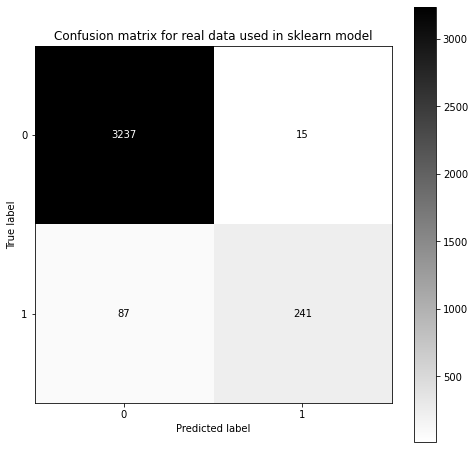

In [28]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=100, min_samples_leaf=10)
tree_model.fit(xtrain,ytrain)
ypred = tree_model.predict(xtest)
sensitivity, specificity, c, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model')

In [29]:
print(f'Sensitivity of the model on given data is {round(sensitivity,4)}\n'
      f'Specificity of the model on given data is {round(specificity,4)}')

Sensitivity of the model on given data is 0.7348
Specificity of the model on given data is 0.9954


<h3 align="center"><font size="10">Część 3</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

In [52]:
xtrain, xtest, ytrain, ytest = train_test_split(cosmos, y, stratify=y, test_size=0.2, train_size=500, random_state=seed)

xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)
xtest.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

xtrain = normalize2(xtrain)
xtest = normalize2(xtest)

xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

classifier = DecisionTreeClassifier(max_depth=2)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_2, d = cm(ytest,ypred, 'Title', False)
own_endtime_2 = (time.time() - start)/loop

In [53]:
classifier = DecisionTreeClassifier(max_depth=100)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_100, d = cm(ytest,ypred, 'Title', False)
own_endtime_100 = (time.time() - start)/loop

In [54]:
classifier = DecisionTreeClassifier(max_depth=10000)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_10000, d = cm(ytest,ypred, 'Title', False)
own_endtime_10000 = (time.time() - start)/loop

<h3 align="center"><font size="10">Model sklearn</font></h3>

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(cosmos, y, stratify=y, test_size=0.2, train_size=0.8, random_state=seed)

xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)
xtest.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

xtrain = normalize2(xtrain)
xtest = normalize2(xtest)

tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain)
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_2, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_2 = (time.time() - start)/loop

In [56]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=100)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain)
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_100, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_100 = (time.time() - start)/loop

In [57]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10000)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain)
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_10000, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_10000 = (time.time() - start)/loop

In [58]:
print(f'The runtime of my own model with max depth = 2 is {own_endtime_2} \n'
      f'The runtime of skl model with max depth = 2 is {skl_endtime_2} \n\n'

      f'The runtime of my own model with max depth = 100 is {own_endtime_100} \n'
      f'The runtime of skl model with max depth = 100 is {skl_endtime_100} \n\n'

      f'The runtime of my own model with max depth = 10000 is {own_endtime_10000} \n'
      f'The runtime of skl model with max depth = 10000 is {skl_endtime_10000} \n\n'

      f'Balanced accuracy of my own model with max depth = 2 is {own_balacc_2} \n'
      f'Balanced accuracy of skl model with max depth = 2 is {skl_balacc_2} \n\n'

      f'Balanced accuracy of my own model with max depth = 100 is {own_balacc_100} \n'
      f'Balanced accuracy of skl model with max depth = 100 is {skl_balacc_100} \n\n'

      f'Balanced accuracy of my own model with max depth = 10000 is {own_balacc_10000} \n'
      f'Balanced accuracy of skl model with max depth = 10000 is {skl_balacc_10000} \n\n')

The runtime of my own model with max depth = 2 is 4.447070622444153 
The runtime of skl model with max depth = 2 is 0.04171900749206543 

The runtime of my own model with max depth = 100 is 7.266457295417785 
The runtime of skl model with max depth = 100 is 0.150268816947937 

The runtime of my own model with max depth = 10000 is 7.174889588356018 
The runtime of skl model with max depth = 10000 is 0.15518708229064943 

Balanced accuracy of my own model with max depth = 2 is 0.9193273182731827 
Balanced accuracy of skl model with max depth = 2 is 0.8734493594935949 

Balanced accuracy of my own model with max depth = 100 is 0.8102462274622746 
Balanced accuracy of skl model with max depth = 100 is 0.8767662676626766 

Balanced accuracy of my own model with max depth = 10000 is 0.8102462274622746 
Balanced accuracy of skl model with max depth = 10000 is 0.880430054300543 




Balanced accuracy modeli sklearn zwiększa się na trzecim miejscu po przecinku dla modeli o większym parametrze max depth, z nieco większym czasem wykonania programu. Nie jest to znaczny wzrost wydajności, ale warty wspomnienia - dla takiego czasu wykonania obliczeń uzasadnione jest korzystanie z większego parametru max depth. Jednocześnie w porównaniu z kosztem wysłania pierwszej sondy użycie algorytmu uczenia maszynowego do wspomagania osiągnięcia większej szansy na sukces misji kosmicznej koszt użycia algorytmu jest nieporównywalnie mniejszy od kosztu wysłania sondy, co sprawia, że jak najbardziej uzasadnione jest poszukiwanie optymalnej głębokości drzewa przy takim problemie.